# Cars Brand Image Classification using CNN

Classifying car brands using convolutional neural networks (CNN) is a machine learning task that involves assigning car images to their respective brand categories. This is an example of a multi-class classification problem where our CNN is expected to predict the brand of a car based on its image. There are several challenges associated with this task:

1. Data Collection: Creating or obtaining a suitable dataset that includes images of cars from various brands is crucial. The dataset should be representative and diverse in terms of brands, models, colors, and other factors that influence brand recognition.

2. Image Preprocessing: Images need to be adequately preprocessed before feeding them into the CNN model. This may involve resizing images, normalization, noise removal, and other preprocessing operations to enhance the data quality.

3. CNN Architecture: Choosing the right CNN architecture to solve the problem of classifying car brands is essential. You can use existing architectures such as VGG, ResNet, or Inception, or customize your own architecture to suit your needs.

4. Model Training: The CNN model needs to be trained on the dataset, which involves multiple epochs of learning to adjust the model's weights for recognizing different car brands.

5. Model Evaluation: After training the model, you need to assess its performance on a test dataset. You can use various metrics such as accuracy or a confusion matrix to evaluate how well the model classifies car brands.

6. Model Optimization: If the model does not achieve satisfactory results, you may need to fine-tune its parameters, change the architecture, or increase the training dataset size to improve its performance.

7. Deployment: After creating and training the CNN model, you can deploy it in an application or service that aims to recognize car brands based on images.

Classifying car brands using convolutional neural networks is an interesting task that can be applied in various domains, such as the automotive industry, traffic monitoring, or road safety. However, its effectiveness depends on data quality and model architecture, requiring careful preparation and experimentation.

## Import libraries

In [1]:
import os
import gdown
import zipfile
import tarfile
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import fnmatch
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import RMSprop

## Datasets

Car brands immages use 100 images of top 50 car brands (US ranking) https://www.kaggle.com/datasets/yamaerenay/100-images-of-top-50-car-brands/data. 
The Most Popular Car Brands in America
According to recent studies, the most popular car brands in America are Ford, Toyota, Chevrolet, Honda, and Nissan. These five brands dominate the American auto market and have consistently been among the top-selling car brands in the country.

Ford has been a leading car brand in America for over a century and is known for its high-quality vehicles, including the most popular Ford F-series pickup. Toyota is another popular car brand in America, known for its reliable and efficient cars, such as the RAV4 and Camry. Chevrolet, a division of General Motors, is also a popular choice for American car buyers, such as the Silverado and Equinox.

Of course, there are many other car brands available in America, including luxury brands like BMW, Mercedes-Benz, and Lexus, as well as relatively small Japanese manufacturers like Subaru and Mazda.

Let's take a look, Which car brands are on the list.

The ranking is based on 2021 sales in the US, but some brands do not have data available.

Here is the Full Ranking List (Top 50)
Toyota, Ford, Chevrolet, Honda, Nissan, Jeep, Hyundai, Kia, Ram Trucks, Subaru, GMC, Volkswagen, BMW, Mazda, Mercedes-Benz, Lexus, Tesla, Dodge, Audi, Buick, Acura, Volvo, Cadillac, Chrysler, Mitsubishi, Land Rover, Lincoln, Porsche, Infiniti, Genesis, Mini, Maserati, Alfa Romeo, Jaguar, Bentley, Ferrari, Lamborghini, Aston Martin, Polestar, Fiat, Rolls-Royce, McLaren, Lucid, Bugatti, Lotus, Rivian, Canoo, Pontiac, Oldsmobile, Rimac,

Even though some car brands have closed down or reduced their operations in the United States market, they are still very popular among American consumers. For example, Pontiac, Saturn and Oldsmobile were all General Motors (GM) brands that were discontinued in the 2000s, but many of their models still have a loyal following in the used car market.

Similarly, other brands like Plymouth and Mercury have also been discontinued, but their cars remain popular among collectors and enthusiasts. Moreover, some foreign brands like Saab and Suzuki have also left the US market, but they still have a dedicated fan base that appreciates their unique features and designs.

Overall, the popularity of a car brand is not only determined by its availability in the market, but also by its reputation, quality, and performance. Even though some car brands have closed down, they have left a lasting impact on the American car industry and continue to be remembered and appreciated by their fans.

## Loading data

Creating the data directory and unpacking the contents into it using archive.zip. Then, in the data directory, create a structure of images/train and images/test directories for 10 classes - car brands. Then copying the contents of the dataset to the train and test directories in an 80/20 ratio.

In [2]:
# Delete the data and models folder if it exists

!rm -Rf data
!rm -Rf models

In [3]:
# Unpacking files from the zip archive

with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [4]:
# Creating directories for training and test files

location = 'data'
directories = ['images', 'images/train', 'images/test']
for directory in directories:
    os.mkdir(os.path.join(location, directory))

In [5]:
# Create data array class names and len of images in classes 

data = []
path = 'data/imgs_zip/imgs/'
for class_ in os.listdir(path):
    count = len(fnmatch.filter(os.listdir(path+class_), '*.jpg'))
    data.append([class_, count])

In [6]:
df = pd.DataFrame(data=data,columns=['classes','count'])

In [7]:
# Show 10 of max images in classes

df = df.sort_values(by=['count'],ascending=False)[:10]
df.reset_index(drop=True)

,classes,count
0,MG,138
1,Daewoo,105
2,Studebaker,102
3,Oldsmobile,102
4,Hudson,102
5,Lincoln,102
6,Genesis,99
7,Ferrari,98
8,Jaguar,95
9,Volkswagen,94


In [8]:
dirs = df['classes'].values
dirs

array(['MG', 'Daewoo', 'Studebaker', 'Oldsmobile', 'Hudson', 'Lincoln',
       'Genesis', 'Ferrari', 'Jaguar', 'Volkswagen'], dtype=object)

In [9]:
# Creating classes of car brands and dividing the files into 80% training and 20% testing

for class_ in dirs:
    #print(str(class_))
    os.mkdir('data/images/train/'+class_)
    os.mkdir('data/images/test/'+class_)
    
    data = os.listdir(path+class_)
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)])):
        shutil.copy(img, 'data/images/train/'+class_)
        
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)]), len(data)):
        shutil.copy(img, 'data/images/test/'+class_)

## Data mining

In this part it shows how many photos there are in the training and test set for a given class. It also shows sample photos for the training and test groups.

In [10]:
# Listing the names of car brand folders from the train folder

data_train = []
path = 'data/images/train/'
for class_ in os.listdir('data/images/train'):
    count = len(fnmatch.filter(os.listdir(path+class_), '*.jpg'))
    data_train.append([class_, count])

In [11]:
data_train

[['Volkswagen', 75],
 ['Studebaker', 82],
 ['Hudson', 82],
 ['Ferrari', 78],
 ['Lincoln', 82],
 ['Daewoo', 84],
 ['MG', 110],
 ['Oldsmobile', 82],
 ['Jaguar', 76],
 ['Genesis', 79]]

In [12]:
# Listing the names of car brand folders from the train folder

data_test = []
path = 'data/images/test/'
for class_ in os.listdir('data/images/test'):
    count = len(fnmatch.filter(os.listdir(path+class_), '*.jpg'))
    data_test.append([class_, count])

In [13]:
data_test

[['Volkswagen', 19],
 ['Studebaker', 20],
 ['Hudson', 20],
 ['Ferrari', 20],
 ['Lincoln', 20],
 ['Daewoo', 21],
 ['MG', 28],
 ['Oldsmobile', 20],
 ['Jaguar', 19],
 ['Genesis', 20]]

In [14]:
# Listing of file names from the sample training folder

os.listdir('data/images/train/'+class_)[:10]

['Genesis_048.jpg',
 'Genesis_060.jpg',
 'Genesis_074.jpg',
 'Genesis_075.jpg',
 'Genesis_061.jpg',
 'Genesis_049.jpg',
 'Genesis_088.jpg',
 'Genesis_077.jpg',
 'Genesis_063.jpg',
 'Genesis_062.jpg']

(-0.5, 295.5, 169.5, -0.5)

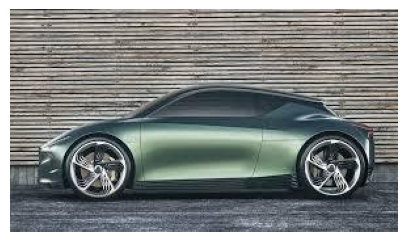

In [15]:
# Listing a sample car image from train images
data = os.listdir('data/images/train/'+class_)
img = image.load_img('data/images/train/'+class_+'/'+data[0])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 99.5, 99.5, -0.5)

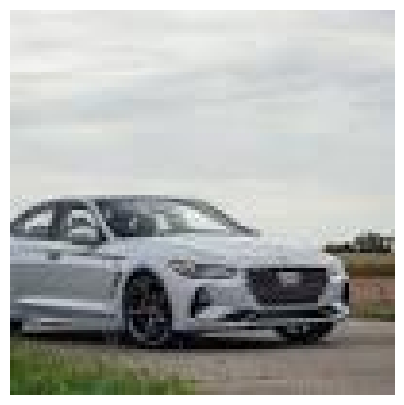

In [16]:
# Listing a sample car image from train images
data = os.listdir('data/images/test/'+class_)
img = image.load_img('data/images/test/'+class_+'/'+data[11])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## Data augmentation

Data augmentation is a technique applied in machine learning, especially for models processing images like Convolutional Neural Networks (CNNs). Its purpose is to increase the amount of available training data by introducing various transformations to existing images. 

Data augmentation is used in this case:

- Increase Data Diversity: Images of car brands can vary in terms of viewing angles, lighting, perspective, or car positions. Data augmentation allows the model to learn to recognize objects in different contexts, which can improve its overall classification ability.
- Reduce Overfitting: Data augmentation helps reduce the problem of model overfitting. By introducing random transformations, the model will not memorize specific training images, which can improve its ability to generalize to new images.
- Boost Training Examples: By generating different variants of images, data augmentation effectively increases the number of available training examples, which can help in training the model, especially for small datasets.
- Enhance Model Stability: The model becomes more stable and flexible, making it less susceptible to variations in the training data.

Ultimately, data augmentation helps improve the quality and performance of the CNN model for classifying car brands by involving it in the learning process with more diverse and transformed data.

In [17]:
# Generate batches of tensor image data with real-time data augmentation

train_datagen = ImageDataGenerator(
     rotation_range=30, # angle range by which the images will randomly rotate
     rescale=1./255.,
     width_shift_range=0.1, # vertical image transformations
     height_shift_range=0.1, # horizontal image transformations
     shear_range=0.1, # random image cropping range
     zoom_range=0.2, # random image zoom range
     horizontal_flip=True, # random flip of half the image in the horizontal plane
     fill_mode='nearest' # strategy for filling newly created pixels that may result from transformations
)

train_gen = train_datagen.flow_from_directory('data/images/train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical')
test_gen = ImageDataGenerator().flow_from_directory('data/images/test',
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 830 images belonging to 10 classes.
Found 207 images belonging to 10 classes.


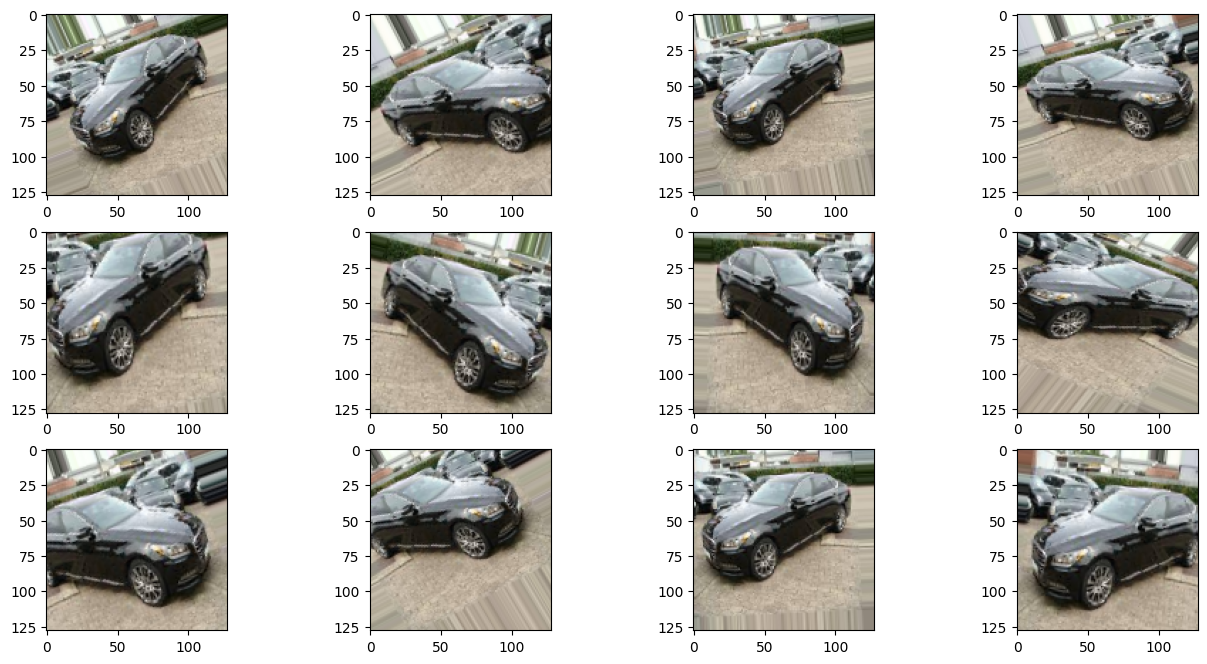

In [18]:
# Sample images obtained using the technique data augmentation
data = os.listdir('data/images/train/'+class_)
img = image.load_img('data/images/train/'+class_+'/'+data[2],target_size=(128, 128))# plt.imshow(img)
#img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 1
plt.figure(figsize=(16, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
        break

##  Model construction

The provided Python function, plot_hist(history), is designed to visualize and plot the training history of a machine learning model, particularly for deep learning models such as neural networks. It takes the model's training history as input and generates two subplots to show changes in training loss and accuracy over epochs.

The purpose of this function is to provide a quick and convenient way to visualize how a machine learning model is performing during training by showing the changes in loss and accuracy metrics over training epochs. This can be helpful for understanding the model's convergence, overfitting, and overall performance.

In [19]:
# Create function to plot model history information

def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig,axes = plt.subplots(2,1, figsize=(8,6))
    fig.suptitle("The model 's evaluation ",fontsize=20)
    axes[0].plot(hist['loss'])
    axes[0].plot(hist['val_loss'])
    #axes[0].set_title('Model Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_yscale('log')
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(hist['accuracy'])
    axes[1].plot(hist['val_accuracy'])
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['accuracy','val_accuracy'])
    plt.show()

### CNN

The provided code defines a Convolutional Neural Network (CNN) model using Keras with the following architecture:

- Input Layer: The model starts with an input layer that takes images of size 128x128 pixels with three channels (RGB).
- Convolutional Layers: Two convolutional layers (Conv2D) with 32 filters of size 5x5 each are added. These layers use the ReLU activation function, which deactivates non-responsive neurons. Both layers use 'Same' padding, meaning input images are padded to the same size.
- Max-Pooling Layer: Following each pair of convolutional layers, there is a Max-Pooling layer (MaxPool2D) with a 2x2 pool size, which helps reduce the dimensionality of processed data and extract significant features.
- Dropout Layer: After each Max-Pooling layer, a Dropout layer is included to assist in model regularization by randomly deactivating some neurons, reducing the risk of overfitting.
- The above steps are repeated in two subsequent blocks: two convolutional layers, a Max-Pooling layer, and a Dropout layer.
- Flatten Layer: After processing through convolutional and Max-Pooling layers, the data is flattened into a single vector using a Flatten layer to be passed to fully connected layers.
- Fully Connected Layers: The model includes two fully connected layers (Dense). The first has 256 neurons with the ReLU activation function, and the second has 10 neurons with the softmax activation function. The final layer serves as the output layer for classifying into 10 classes. The softmax function generates probabilities for each class.
- Model Compilation: The model is compiled using the 'categorical_crossentropy' loss function, 'rmsprop' optimizer, and accuracy metric.
- Model Summary: Finally, the model.summary() function is called to generate a summary of the model's architecture, displaying the number of parameters and dimensions for each layer.

This model is a typical example of a CNN for image classification. It is designed for recognizing objects in 128x128-pixel images and is structured to leverage convolutions, max-pooling, and regularization to effectively learn and classify images.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                  activation ='relu', input_shape = (128, 128,3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = "softmax"))
model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [21]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=64, epochs=20)

Epoch 1/20
26/26 [==============================] - 21s 792ms/step - loss: 3.1560 - accuracy: 0.1060 - val_loss: 2.3925 - val_accuracy: 0.1208
Epoch 2/20
26/26 [==============================] - 21s 813ms/step - loss: 2.2952 - accuracy: 0.1325 - val_loss: 26.8511 - val_accuracy: 0.1353
Epoch 3/20
26/26 [==============================] - 21s 816ms/step - loss: 2.2613 - accuracy: 0.1542 - val_loss: 67.2933 - val_accuracy: 0.1691
Epoch 4/20
26/26 [==============================] - 21s 823ms/step - loss: 2.2145 - accuracy: 0.1578 - val_loss: 116.8745 - val_accuracy: 0.1643
Epoch 5/20
26/26 [==============================] - 21s 823ms/step - loss: 2.2292 - accuracy: 0.1711 - val_loss: 91.0863 - val_accuracy: 0.1546
Epoch 6/20
26/26 [==============================] - 21s 820ms/step - loss: 2.2140 - accuracy: 0.1783 - val_loss: 88.5415 - val_accuracy: 0.1449
Epoch 7/20
26/26 [==============================] - 23s 883ms/step - loss: 2.2016 - accuracy: 0.1590 - val_loss: 102.7077 - val_accuracy

In [22]:
hist_df_cnn = pd.DataFrame(history.history)

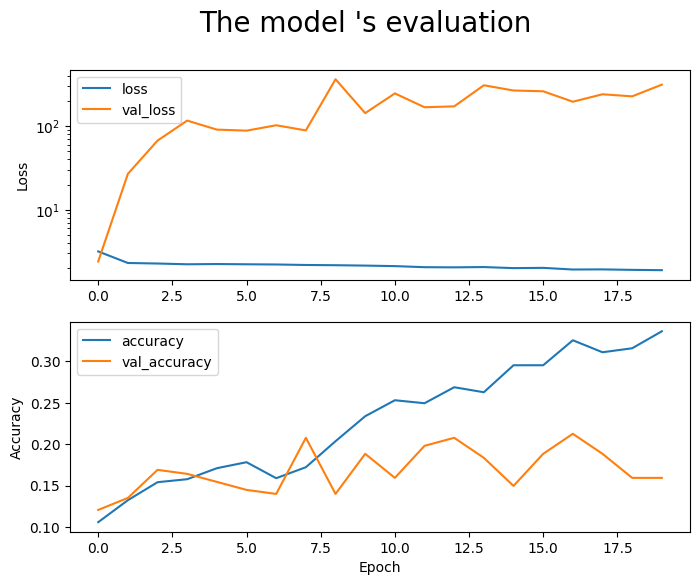

In [23]:
plot_hist(history)

In [24]:
os.mkdir('models')

In [25]:
model.save('models/cnn_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Vgg16 

The described model uses Transfer Learning the VGG16 architecture as a base (without fully connected layers) and adds its own fully connected layers for image classification. In summary, this model uses the VGG16 architecture for feature extraction from images and adds fully connected layers for classification. By freezing the weights of the base VGG16 model, it retains the ability to extract features but doesn't retrain the weights. This is often used when you have a small amount of training data and want to leverage pre-trained models to improve performance on new data.

In [26]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [27]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [28]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=64, epochs=20)

Epoch 1/20
26/26 [==============================] - 34s 1s/step - loss: 2.3985 - accuracy: 0.2241 - val_loss: 32.1897 - val_accuracy: 0.2899
Epoch 2/20
26/26 [==============================] - 36s 1s/step - loss: 1.7901 - accuracy: 0.3855 - val_loss: 39.3025 - val_accuracy: 0.3092
Epoch 3/20
26/26 [==============================] - 37s 1s/step - loss: 1.6020 - accuracy: 0.4325 - val_loss: 39.3573 - val_accuracy: 0.3720
Epoch 4/20
26/26 [==============================] - 39s 1s/step - loss: 1.4241 - accuracy: 0.5229 - val_loss: 35.1826 - val_accuracy: 0.4300
Epoch 5/20
26/26 [==============================] - 38s 1s/step - loss: 1.3700 - accuracy: 0.5229 - val_loss: 42.5059 - val_accuracy: 0.4058
Epoch 6/20
26/26 [==============================] - 38s 1s/step - loss: 1.2647 - accuracy: 0.5651 - val_loss: 44.3824 - val_accuracy: 0.3768
Epoch 7/20
26/26 [==============================] - 38s 1s/step - loss: 1.1360 - accuracy: 0.6169 - val_loss: 48.4591 - val_accuracy: 0.3913
Epoch 8/20
26

In [29]:
hist_df_vgg = pd.DataFrame(history.history)

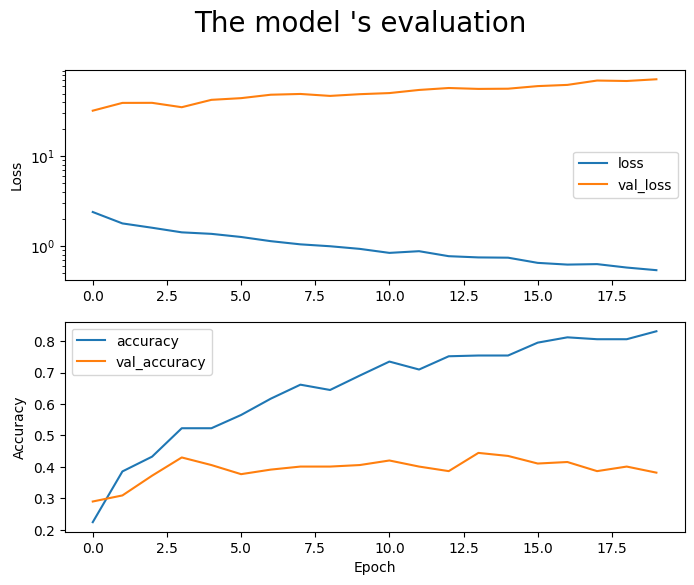

In [30]:
plot_hist(history)

In [31]:
model.save('models/vgg16_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### ResNet50 

The described model uses Transfer Learning the ResNet50 architecture as a base (excluding the fully connected layers) and extends it with additional layers for image classification. In summary, this model utilizes the ResNet50 architecture for feature extraction from images and adds fully connected layers for classification. By freezing the weights of the base ResNet50 model, it retains the ability to extract features but doesn't retrain the weights. This approach is commonly used when there is limited training data, and leveraging pre-trained models can enhance performance on new data.

In [32]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [33]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 31979146 (121.99 MB)
Trainable params: 8391434 (32.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [34]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=64, epochs=20)

Epoch 1/20
26/26 [==============================] - 13s 477ms/step - loss: 2.6426 - accuracy: 0.1012 - val_loss: 4.4087 - val_accuracy: 0.1111
Epoch 2/20
26/26 [==============================] - 12s 474ms/step - loss: 2.3038 - accuracy: 0.1253 - val_loss: 5.3813 - val_accuracy: 0.1014
Epoch 3/20
26/26 [==============================] - 12s 471ms/step - loss: 2.2985 - accuracy: 0.1494 - val_loss: 6.5607 - val_accuracy: 0.1111
Epoch 4/20
26/26 [==============================] - 12s 474ms/step - loss: 2.2640 - accuracy: 0.1530 - val_loss: 7.0398 - val_accuracy: 0.1014
Epoch 5/20
26/26 [==============================] - 12s 477ms/step - loss: 2.2530 - accuracy: 0.1590 - val_loss: 6.9148 - val_accuracy: 0.1208
Epoch 6/20
26/26 [==============================] - 12s 481ms/step - loss: 2.2280 - accuracy: 0.1639 - val_loss: 7.5196 - val_accuracy: 0.1256
Epoch 7/20
26/26 [==============================] - 13s 486ms/step - loss: 2.2034 - accuracy: 0.1964 - val_loss: 8.4828 - val_accuracy: 0.1111

In [35]:
hist_df_resnet = pd.DataFrame(history.history)

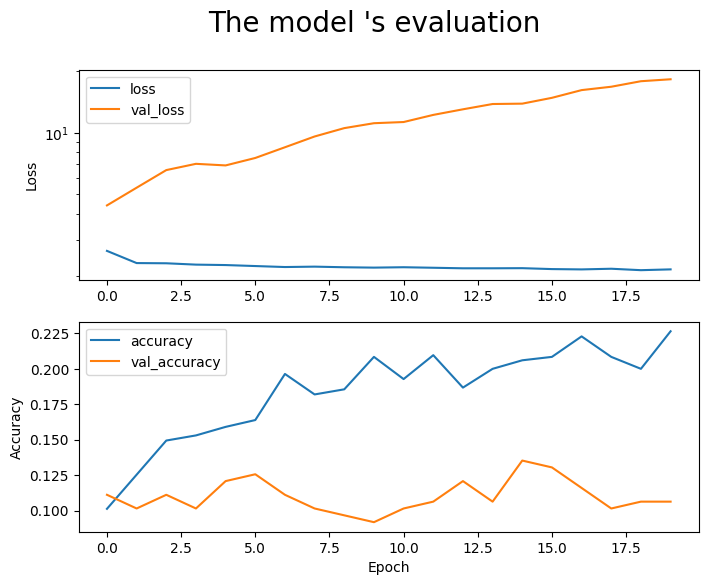

In [36]:
plot_hist(history)

In [37]:
model.save('models/resnet50_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### InceptionV3

The described model uses Transfer Learning the InceptionV3 architecture as a base (excluding the fully connected layers) and supplements it with additional layers for image classification. In summary, this model leverages the InceptionV3 architecture for feature extraction from images and introduces fully connected layers for classification. By freezing the weights of the base InceptionV3 model, it retains the capability to extract features but doesn't retrain the weights. This approach is commonly employed when there is a limited amount of training data, and utilizing pre-trained models can enhance performance on new data.

In [38]:
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [39]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 23902762 (91.18 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [40]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=64, epochs=20)

Epoch 1/20
26/26 [==============================] - 8s 268ms/step - loss: 7.3099 - accuracy: 0.1542 - val_loss: 5.6307 - val_accuracy: 0.1014
Epoch 2/20
26/26 [==============================] - 7s 260ms/step - loss: 2.2127 - accuracy: 0.1964 - val_loss: 17.0929 - val_accuracy: 0.1111
Epoch 3/20
26/26 [==============================] - 7s 260ms/step - loss: 2.0839 - accuracy: 0.2494 - val_loss: 20.7856 - val_accuracy: 0.0918
Epoch 4/20
26/26 [==============================] - 7s 259ms/step - loss: 2.0008 - accuracy: 0.2855 - val_loss: 26.0918 - val_accuracy: 0.1256
Epoch 5/20
26/26 [==============================] - 7s 255ms/step - loss: 1.9216 - accuracy: 0.3193 - val_loss: 30.7178 - val_accuracy: 0.1063
Epoch 6/20
26/26 [==============================] - 7s 256ms/step - loss: 1.8116 - accuracy: 0.3699 - val_loss: 30.1925 - val_accuracy: 0.0773
Epoch 7/20
26/26 [==============================] - 7s 261ms/step - loss: 1.7513 - accuracy: 0.3783 - val_loss: 35.3033 - val_accuracy: 0.0676


In [41]:
hist_df_inception = pd.DataFrame(history.history)

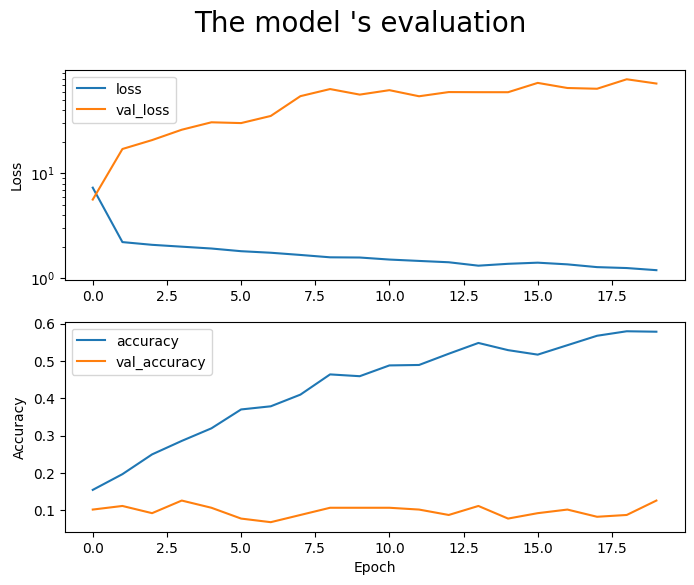

In [42]:
plot_hist(history)

In [43]:
model.save('models/inceptionv3_model_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


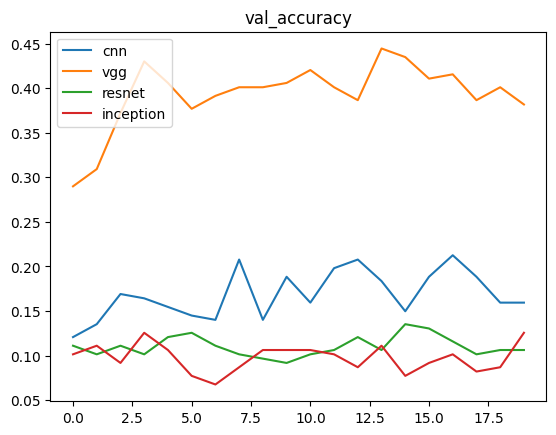

In [141]:
# Create val_accuracy plots

fig, ax = plt.subplots()
ax.set_title('val_accuracy')
ax.plot(hist_df_cnn.index, hist_df_cnn['val_accuracy'],label='cnn')
ax.plot(hist_df_vgg.index, hist_df_vgg['val_accuracy'], label='vgg')
ax.plot(hist_df_resnet.index, hist_df_resnet['val_accuracy'], label='resnet')
ax.plot(hist_df_inception.index, hist_df_inception['val_accuracy'], label='inception')
legend = ax.legend(loc='upper left')

plt.show()

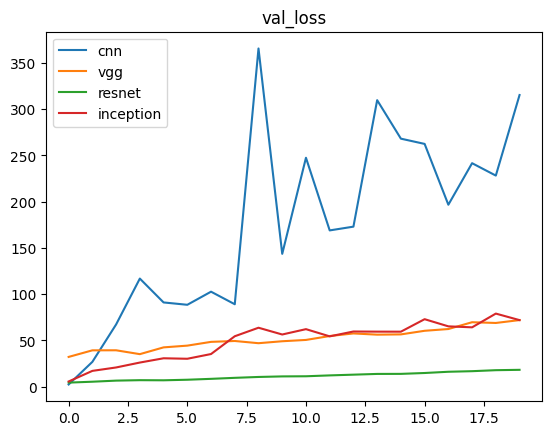

In [140]:
# Create val_loss plots

fig, ax = plt.subplots()
ax.set_title('val_loss')
ax.plot(hist_df_cnn.index, hist_df_cnn['val_loss'],label='cnn')
ax.plot(hist_df_vgg.index, hist_df_vgg['val_loss'], label='vgg')
ax.plot(hist_df_resnet.index, hist_df_resnet['val_loss'], label='resnet')
ax.plot(hist_df_inception.index, hist_df_inception['val_loss'], label='inception')
legend = ax.legend(loc='upper left')

plt.show()

Val_accuracy stands for "validation accuracy." In the context of machine learning and deep learning, validation accuracy is a measure of a model's effectiveness in classifying or predicting on new, unseen validation data.

During the model training process, the training data is used to adjust the model's weights and parameters. Subsequently, the model is evaluated on the validation data, which was not used during training. Validation accuracy measures how well the model generalizes to new data and is a key metric for assessing model performance.

Accuracy is a commonly used evaluation metric, representing the percentage of correctly classified examples on the validation dataset. The higher the val_accuracy value, the better the model performs in classifying new data. However, it's important to note that accuracy alone may not always provide a complete picture of a model's performance, especially in cases of imbalanced classes or other data nuances. 


Val_loss stands for "validation loss." In the context of machine learning, it is a measure of the model's loss function on the validation dataset.

The loss function is a metric that assesses how well a model is performing during training. A lower val_loss indicates that the model is doing a better job in minimizing errors on the validation data. The loss function measures the discrepancy between the model's predictions and the actual labels (responses) on the validation dataset.

During the model training process, the goal is to minimize val_loss, which means that the model is attempting to fit the validation data as closely as possible. However, it's important to consider val_loss alongside other metrics, such as accuracy (val_accuracy), to get a more comprehensive view of the model's performance. Often, a balance is sought between minimizing loss and maximizing accuracy to achieve an effective model capable of generalizing to new data.

In the case of the tested models, the vgg model has the highest val_accuracy with the lowest val_loss value

## Evaluation of models on the test set

In this section, I will evaluate the performance of the models on the test set. I will use the confusion matrix metric to evaluate how well the model performs at classifying car brands.

In [66]:
# Preparation of test data

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    'data/images/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 207 images belonging to 10 classes.


In [67]:
# Raad class indices

test_generator.class_indices

{'Daewoo': 0,
 'Ferrari': 1,
 'Genesis': 2,
 'Hudson': 3,
 'Jaguar': 4,
 'Lincoln': 5,
 'MG': 6,
 'Oldsmobile': 7,
 'Studebaker': 8,
 'Volkswagen': 9}

In [68]:
classes = list(test_generator.class_indices.keys())

In [69]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

In [70]:
# Load models
cnn_model = load_model('models/cnn_model_10.h5')
vgg_model = load_model('models/vgg16_model_10.h5')
resnet_model = load_model('models/resnet50_model_10.h5')
inc_model = load_model('models/inceptionv3_model_10.h5')

### CNN

I evaluate the performance of the CNN model on the test set

In [71]:
# Predict cnn model

y_prob = cnn_model.predict(test_generator, test_generator.samples)

207/207 [==============================] - 2s 10ms/step


In [72]:
y_pred_cnn = np.argmax(y_prob, axis=1)

In [73]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_cnn)
cm

array([[ 6,  0,  1,  0,  0,  0,  5,  3,  3,  3],
       [ 2,  7,  0,  0,  0,  1,  9,  0,  0,  1],
       [ 3,  1,  3,  1,  0,  1,  7,  1,  2,  1],
       [ 0,  0,  1, 10,  0,  3,  2,  1,  1,  2],
       [ 5,  0,  1,  3,  0,  0,  5,  0,  5,  0],
       [ 2,  0,  0,  6,  0,  6,  4,  0,  2,  0],
       [ 4,  0,  6,  2,  0,  2,  8,  0,  2,  4],
       [ 6,  0,  0,  0,  0,  1,  7,  2,  2,  2],
       [ 4,  1,  0,  0,  0,  1,  6,  0,  5,  3],
       [ 6,  0,  0,  1,  0,  0,  3,  1,  3,  5]])

In [74]:
def plot_confusion_matrix(cm):
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classes)
    fig, ax = plt.subplots(figsize=(10,10))
    display.plot(ax=ax, xticks_rotation='vertical')
    plt.show()

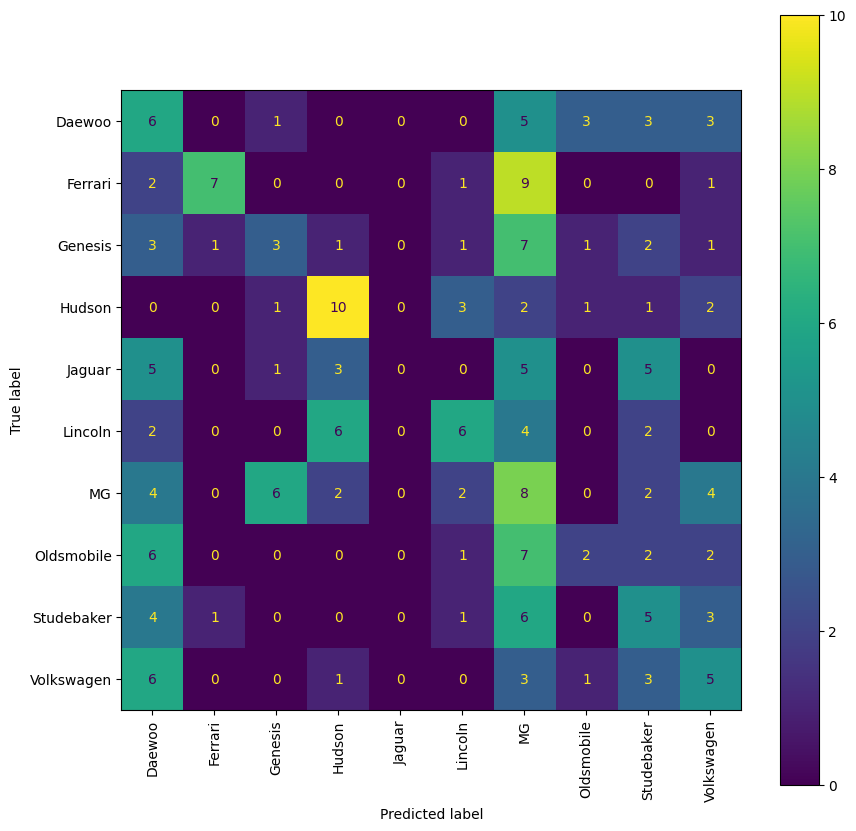

In [75]:
plot_confusion_matrix(cm)

In [76]:
print(classification_report(y_true, y_pred_cnn, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      Daewoo       0.16      0.29      0.20        21
     Ferrari       0.78      0.35      0.48        20
     Genesis       0.25      0.15      0.19        20
      Hudson       0.43      0.50      0.47        20
      Jaguar       0.00      0.00      0.00        19
     Lincoln       0.40      0.30      0.34        20
          MG       0.14      0.29      0.19        28
  Oldsmobile       0.25      0.10      0.14        20
  Studebaker       0.20      0.25      0.22        20
  Volkswagen       0.24      0.26      0.25        19

    accuracy                           0.25       207
   macro avg       0.29      0.25      0.25       207
weighted avg       0.28      0.25      0.25       207



/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### VGG16

I evaluate the performance of the VGG16 model on the test set

In [77]:
# Predict model

y_prob = vgg_model.predict(test_generator, test_generator.samples)

207/207 [==============================] - 8s 40ms/step


In [78]:
y_pred_vgg = np.argmax(y_prob, axis=1)

In [79]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_vgg)
cm

array([[11,  1,  1,  0,  3,  1,  1,  0,  0,  3],
       [ 1, 13,  0,  0,  3,  0,  3,  0,  0,  0],
       [ 0,  0,  2,  1,  3,  3,  6,  1,  0,  4],
       [ 0,  1,  1, 11,  1,  2,  2,  0,  2,  0],
       [ 0,  0,  1,  1, 14,  1,  2,  0,  0,  0],
       [ 0,  0,  1,  3,  5,  8,  1,  0,  2,  0],
       [ 1,  1,  3,  0,  5,  1, 12,  0,  0,  5],
       [ 0,  1,  0,  0,  2,  2,  3,  7,  5,  0],
       [ 0,  0,  0,  0,  1,  1,  2,  5,  8,  3],
       [ 3,  1,  1,  2,  1,  0,  1,  0,  1,  9]])

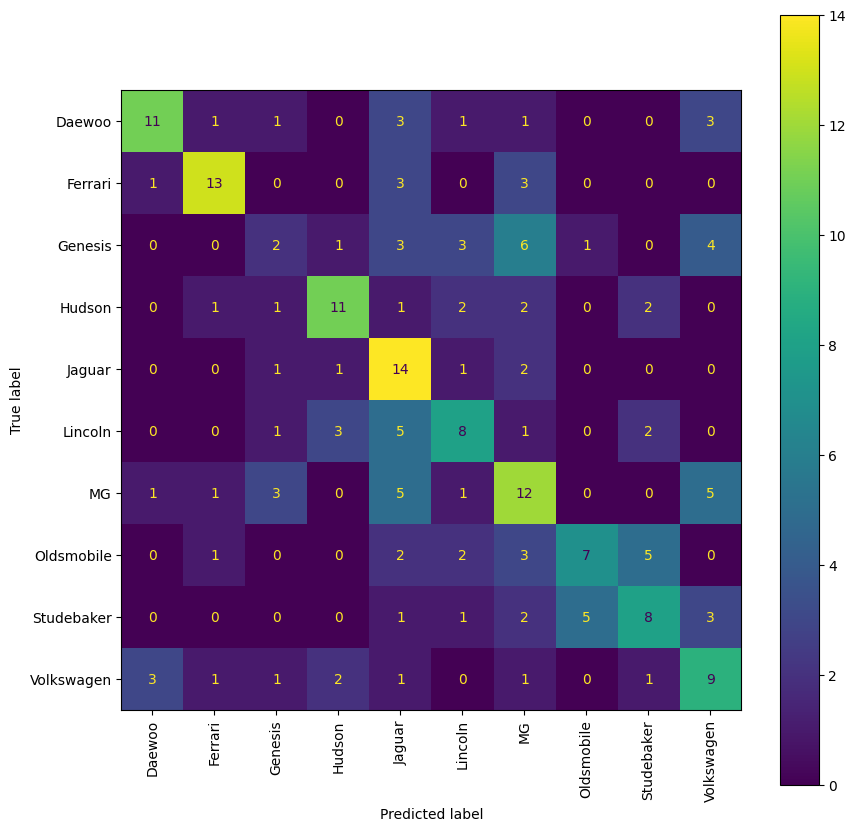

In [80]:
plot_confusion_matrix(cm)

In [81]:
print(classification_report(y_true, y_pred_vgg, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      Daewoo       0.69      0.52      0.59        21
     Ferrari       0.72      0.65      0.68        20
     Genesis       0.20      0.10      0.13        20
      Hudson       0.61      0.55      0.58        20
      Jaguar       0.37      0.74      0.49        19
     Lincoln       0.42      0.40      0.41        20
          MG       0.36      0.43      0.39        28
  Oldsmobile       0.54      0.35      0.42        20
  Studebaker       0.44      0.40      0.42        20
  Volkswagen       0.38      0.47      0.42        19

    accuracy                           0.46       207
   macro avg       0.47      0.46      0.45       207
weighted avg       0.47      0.46      0.45       207



### ResNet50

I evaluate the performance of the ResNet50 model on the test set

In [82]:
# Predict model

y_prob = resnet_model.predict(test_generator, test_generator.samples)

207/207 [==============================] - 6s 25ms/step


In [83]:
y_pred_res = np.argmax(y_prob, axis=1)

In [84]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_res)
cm

array([[ 4,  1,  0,  1,  0,  0,  7,  4,  1,  3],
       [ 1,  2,  0,  0,  0,  0,  6,  4,  7,  0],
       [ 1,  1,  0,  3,  0,  0,  7,  2,  2,  4],
       [ 2,  2,  0, 10,  0,  1,  2,  0,  3,  0],
       [ 3,  0,  0,  4,  0,  0,  3,  3,  6,  0],
       [ 3,  0,  0,  6,  0,  0,  2,  2,  6,  1],
       [ 5,  1,  1,  4,  0,  0, 12,  2,  2,  1],
       [ 3,  2,  0,  1,  0,  0,  2,  5,  7,  0],
       [ 0,  0,  0,  0,  0,  0,  6,  4, 10,  0],
       [ 9,  0,  0,  1,  0,  0,  6,  1,  2,  0]])

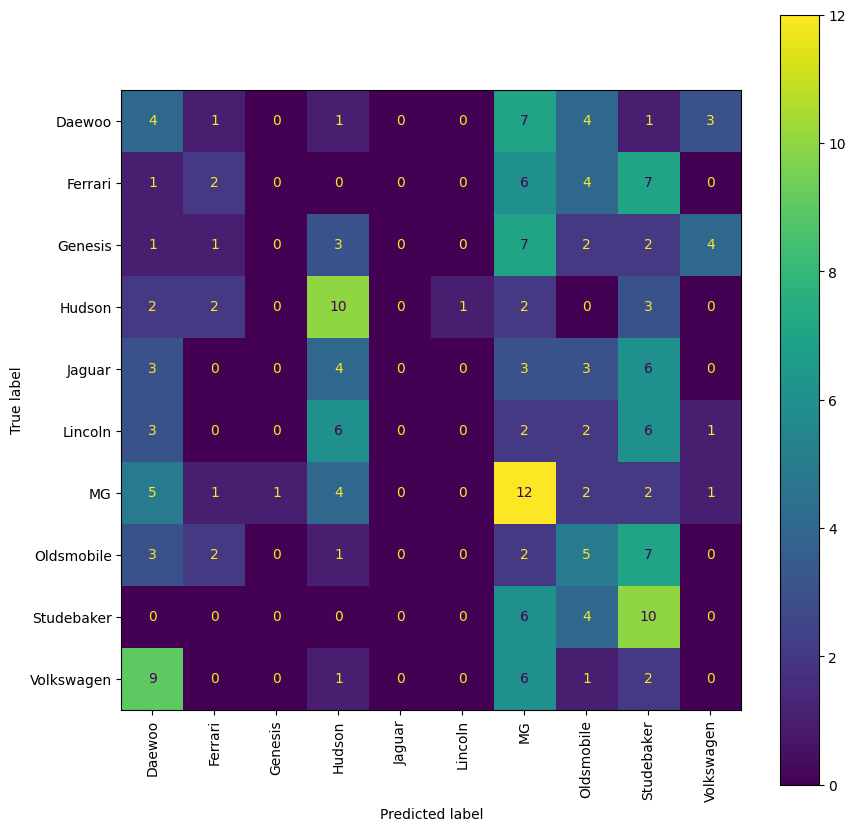

In [85]:
plot_confusion_matrix(cm)

In [86]:
print(classification_report(y_true, y_pred_res, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      Daewoo       0.13      0.19      0.15        21
     Ferrari       0.22      0.10      0.14        20
     Genesis       0.00      0.00      0.00        20
      Hudson       0.33      0.50      0.40        20
      Jaguar       0.00      0.00      0.00        19
     Lincoln       0.00      0.00      0.00        20
          MG       0.23      0.43      0.30        28
  Oldsmobile       0.19      0.25      0.21        20
  Studebaker       0.22      0.50      0.30        20
  Volkswagen       0.00      0.00      0.00        19

    accuracy                           0.21       207
   macro avg       0.13      0.20      0.15       207
weighted avg       0.14      0.21      0.16       207



/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionV3

I evaluate the performance of the InceptionV3 model on the test set

In [87]:
# Predict model

y_prob = inc_model.predict(test_generator, test_generator.samples)

207/207 [==============================] - 3s 14ms/step


In [88]:
y_pred_inc = np.argmax(y_prob, axis=1)

In [89]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred_inc)
cm

array([[13,  0,  1,  0,  1,  1,  3,  0,  0,  2],
       [ 2,  5,  1,  1,  4,  0,  5,  2,  0,  0],
       [ 3,  0,  3,  2,  1,  2,  7,  1,  0,  1],
       [ 0,  0,  3, 13,  1,  0,  1,  2,  0,  0],
       [ 0,  0,  0,  1,  9,  4,  3,  1,  0,  1],
       [ 1,  0,  1,  3,  1,  9,  2,  1,  2,  0],
       [ 2,  0,  2,  0,  5,  3,  7,  0,  7,  2],
       [ 2,  0,  0,  0,  2,  2,  4,  5,  5,  0],
       [ 0,  0,  0,  0,  2,  2,  1,  4, 11,  0],
       [ 4,  0,  0,  2,  3,  1,  3,  0,  1,  5]])

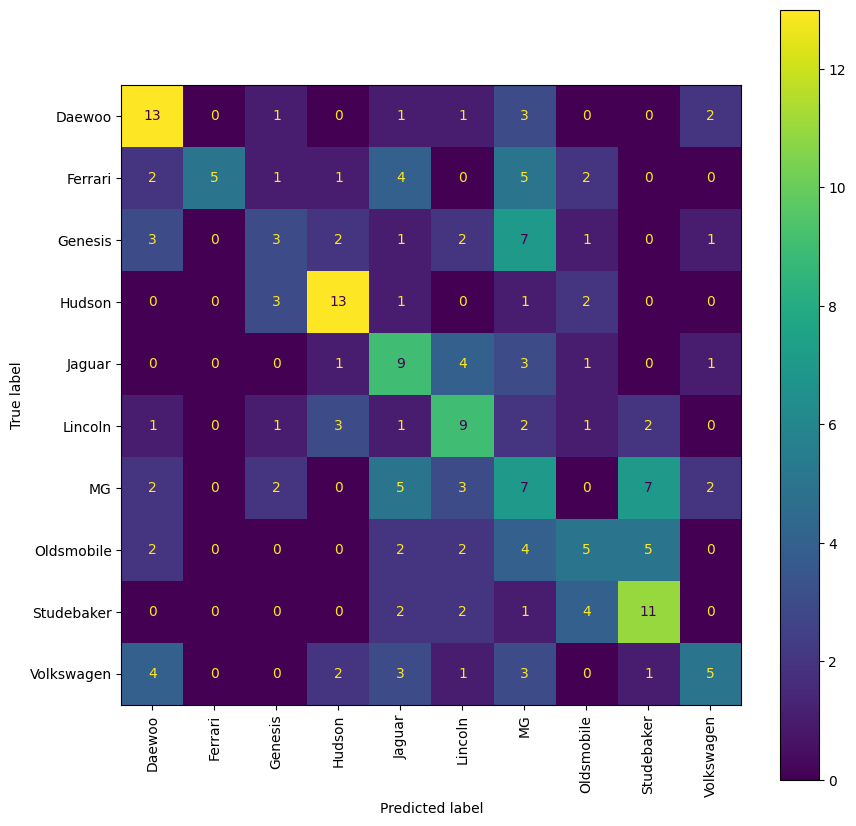

In [90]:
plot_confusion_matrix(cm)

In [91]:
print(classification_report(y_true, y_pred_inc, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

      Daewoo       0.48      0.62      0.54        21
     Ferrari       1.00      0.25      0.40        20
     Genesis       0.27      0.15      0.19        20
      Hudson       0.59      0.65      0.62        20
      Jaguar       0.31      0.47      0.38        19
     Lincoln       0.38      0.45      0.41        20
          MG       0.19      0.25      0.22        28
  Oldsmobile       0.31      0.25      0.28        20
  Studebaker       0.42      0.55      0.48        20
  Volkswagen       0.45      0.26      0.33        19

    accuracy                           0.39       207
   macro avg       0.44      0.39      0.38       207
weighted avg       0.43      0.39      0.38       207



## Summary

W celu oceny wynikw zbudujemy zbiorcze dataframe dla macierzy pomyłek i f1-score na podstawie wynikw uzyskanych dla poszczegolnych modeli.

In [92]:
report_cnn = classification_report(y_true, y_pred_cnn, target_names=test_generator.class_indices.keys(), output_dict=True)
report_vgg = classification_report(y_true, y_pred_vgg, target_names=test_generator.class_indices.keys(), output_dict=True)
report_res = classification_report(y_true, y_pred_res, target_names=test_generator.class_indices.keys(), output_dict=True)
report_inc = classification_report(y_true, y_pred_inc, target_names=test_generator.class_indices.keys(), output_dict=True)

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

In [97]:
df_rep_cnn = pd.DataFrame(report_cnn).transpose()
df_rep_vgg = pd.DataFrame(report_vgg).transpose()
df_rep_res = pd.DataFrame(report_res).transpose()
df_rep_inc = pd.DataFrame(report_inc).transpose()

In [226]:
precision = pd.DataFrame(df_rep_cnn.precision)
precision.rename(columns = {'precision':'cnn'}, inplace = True)
precision['vgg'] = df_rep_vgg.precision.values
precision['res'] = df_rep_res.precision.values
precision['inc'] = df_rep_inc.precision.values

In [227]:
precision

,cnn,vgg,res,inc
Daewoo,0.157895,0.687500,0.129032,0.481481
Ferrari,0.777778,0.722222,0.222222,1.000000
Genesis,0.250000,0.200000,0.000000,0.272727
Hudson,0.434783,0.611111,0.333333,0.590909
Jaguar,0.000000,0.368421,0.000000,0.310345
Lincoln,0.400000,0.421053,0.000000,0.375000
MG,0.142857,0.363636,0.226415,0.194444
Oldsmobile,0.250000,0.538462,0.185185,0.312500
Studebaker,0.200000,0.444444,0.217391,0.423077
Volkswagen,0.238095,0.375000,0.000000,0.454545


<Axes: >

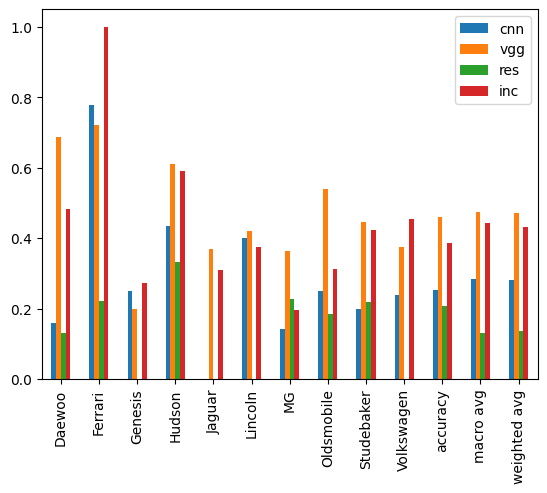

In [146]:
precision.plot.bar()

In [155]:
f1score = pd.DataFrame(df_rep_cnn['f1-score'])
f1score.rename(columns = {'f1-score':'cnn'}, inplace = True)
f1score['vgg'] = df_rep_vgg['f1-score'].values
f1score['res'] = df_rep_res['f1-score'].values
f1score['inc'] = df_rep_inc['f1-score'].values

In [156]:
f1score

,cnn,vgg,res,inc
Daewoo,0.203390,0.594595,0.153846,0.541667
Ferrari,0.482759,0.684211,0.137931,0.400000
Genesis,0.187500,0.133333,0.000000,0.193548
Hudson,0.465116,0.578947,0.400000,0.619048
Jaguar,0.000000,0.491228,0.000000,0.375000
Lincoln,0.342857,0.410256,0.000000,0.409091
MG,0.190476,0.393443,0.296296,0.218750
Oldsmobile,0.142857,0.424242,0.212766,0.277778
Studebaker,0.222222,0.421053,0.303030,0.478261
Volkswagen,0.250000,0.418605,0.000000,0.333333


<Axes: >

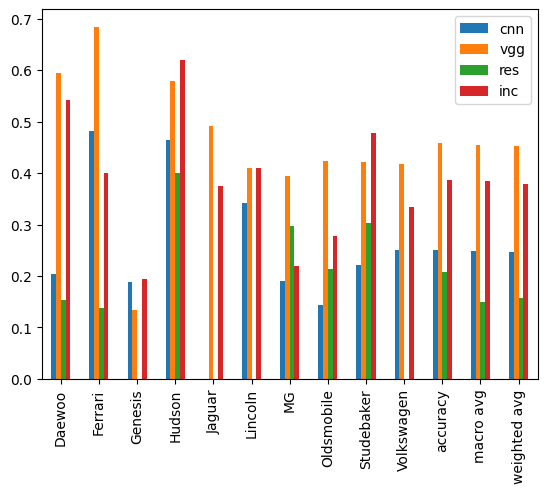

In [157]:
f1score.plot.bar()

Analyzing the obtained results, it can be noticed that both the precision coefficients and the f1-score are the highest for the vgg model. To sum up, the best results when training the model - the highest val_accuracy has the vgg model with the lowest val_loss value - were obtained for the vgg model. The average precision value for 10 classes of car brands was also the highest for the vgg model and amounted to over 45%.

In the following, we will analyze some of the results obtained on the test data for the vgg model. For this purpose, we will build an error dataframe with car brand and prediction classes.

In [159]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred_vgg}, index=test_generator.filenames)
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred'])
print(f'Errors in all test files: {test_generator.n}')
errors['is_incorrect'].sum()

Errors in all test files: 207


112

In [160]:
def plot_img(model, path, file):
    img_path = os.path.join(path, file)
    img = image.load_img(img_path)
    new_img = image.load_img(img_path, target_size=(128, 128))
    img = image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    
    img_class = model.predict(img)
    img_class_index =np.argmax(img_class)
    classname = classes[img_class_index]
    prediction = model.predict(img).max()
    
    pred_dict = {"Class":classname, "Probability":prediction}
    print(pred_dict)
    
    #ploting image with predicted class name        
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(classname)
    plt.show()

In [161]:
test_generator.class_indices

{'Daewoo': 0,
 'Ferrari': 1,
 'Genesis': 2,
 'Hudson': 3,
 'Jaguar': 4,
 'Lincoln': 5,
 'MG': 6,
 'Oldsmobile': 7,
 'Studebaker': 8,
 'Volkswagen': 9}

#### Daewoo

In [163]:
errors[(errors['y_true'] == 0) & (errors['is_incorrect'] == False)]

,y_true,y_pred,is_incorrect
Daewoo/Daewoo_045.jpg,0,0,False
Daewoo/Daewoo_046.jpg,0,0,False
Daewoo/Daewoo_051.jpg,0,0,False
Daewoo/Daewoo_052.jpg,0,0,False
Daewoo/Daewoo_054.jpg,0,0,False
Daewoo/Daewoo_078.jpg,0,0,False
Daewoo/Daewoo_079.jpg,0,0,False
Daewoo/Daewoo_084.jpg,0,0,False
Daewoo/Daewoo_085.jpg,0,0,False
Daewoo/Daewoo_090.jpg,0,0,False


1/1 [==============================] - 0s 48ms/step
{'Class': 'Daewoo', 'Probability': 0.64750576}


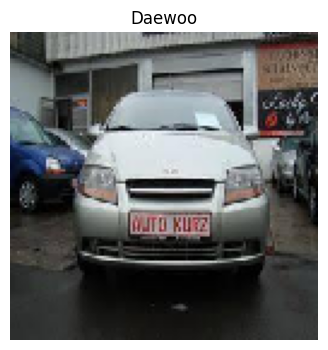

In [164]:
plot_img(vgg_model,'data/images/test','Daewoo/Daewoo_045.jpg')

In [165]:
errors[(errors['y_true'] == 0) & (errors['is_incorrect'] == True)]

,y_true,y_pred,is_incorrect
Daewoo/Daewoo_044.jpg,0,1,True
Daewoo/Daewoo_047.jpg,0,4,True
Daewoo/Daewoo_050.jpg,0,9,True
Daewoo/Daewoo_053.jpg,0,9,True
Daewoo/Daewoo_083.jpg,0,4,True
Daewoo/Daewoo_086.jpg,0,5,True
Daewoo/Daewoo_087.jpg,0,9,True
Daewoo/Daewoo_091.jpg,0,4,True
Daewoo/Daewoo_092.jpg,0,6,True
Daewoo/Daewoo_093.jpg,0,2,True


1/1 [==============================] - 0s 53ms/step
{'Class': 'Ferrari', 'Probability': 0.7356818}


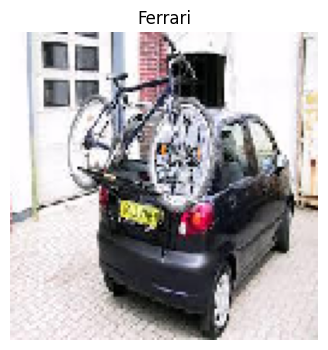

In [170]:
plot_img(vgg_model,'data/images/test','Daewoo/Daewoo_044.jpg')

In this case, the incorrect identification was most likely caused by the bicycle installed on the rack.

#### Ferrari

In [171]:
errors[(errors['y_true'] == 1) & (errors['is_incorrect'] == False)]

,y_true,y_pred,is_incorrect
Ferrari/Ferrari_040.jpg,1,1,False
Ferrari/Ferrari_042.jpg,1,1,False
Ferrari/Ferrari_054.jpg,1,1,False
Ferrari/Ferrari_055.jpg,1,1,False
Ferrari/Ferrari_056.jpg,1,1,False
Ferrari/Ferrari_057.jpg,1,1,False
Ferrari/Ferrari_069.jpg,1,1,False
Ferrari/Ferrari_081.jpg,1,1,False
Ferrari/Ferrari_082.jpg,1,1,False
Ferrari/Ferrari_083.jpg,1,1,False


1/1 [==============================] - 0s 48ms/step
{'Class': 'Ferrari', 'Probability': 0.7517441}


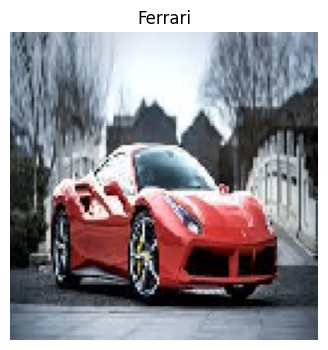

In [172]:
plot_img(vgg_model,'data/images/test','Ferrari/Ferrari_040.jpg')

In [173]:
errors[(errors['y_true'] == 1) & (errors['is_incorrect'] == True)]

,y_true,y_pred,is_incorrect
Ferrari/Ferrari_041.jpg,1,4,True
Ferrari/Ferrari_043.jpg,1,4,True
Ferrari/Ferrari_068.jpg,1,0,True
Ferrari/Ferrari_080.jpg,1,4,True
Ferrari/Ferrari_092.jpg,1,6,True
Ferrari/Ferrari_094.jpg,1,6,True
Ferrari/Ferrari_096.jpg,1,6,True


1/1 [==============================] - 0s 58ms/step
{'Class': 'Jaguar', 'Probability': 0.4851158}


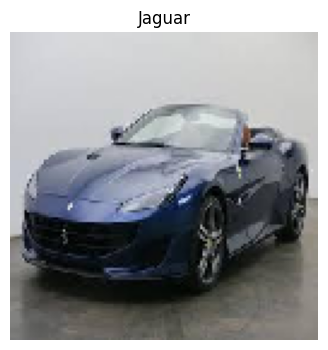

In [174]:
plot_img(vgg_model,'data/images/test','Ferrari/Ferrari_041.jpg')

In this case, this Ferrari model closely resembles the Jaguar F-type and this probably contributed to the poor rating of the model.

# Building a new model for a larger set of photos of car brands

## Dataset 
60,000+ Images of Cars - The Car Connection Picture Dataset
https://www.kaggle.com/datasets/prondeau/the-car-connection-picture-dataset

First of all, I download the archive, unpack it, and prepare the directories. I will use the 10 largest classes

In [175]:
url = 'https://drive.google.com/file/d/1BgoGWzoGKhF6nxG9jqVDA0B1_P67Eq5Z/view?usp=drive_link'
output = 'carsimg.tar.gz'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1BgoGWzoGKhF6nxG9jqVDA0B1_P67Eq5Z
From (redirected): https://drive.google.com/uc?id=1BgoGWzoGKhF6nxG9jqVDA0B1_P67Eq5Z&confirm=t&uuid=351ff916-a974-41b6-b2d2-51a053e88646
To: /Users/marcin/workspace/Car_brand_CNN/carsimg.tar.gz
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 674M/674M [01:05<00:00, 10.3MB/s]


'carsimg.tar.gz'

In [177]:
file = tarfile.open(output)
file.extractall('.')
file.close()

In [178]:
!rm -Rf data2

In [179]:
# Creating directories for training and test files
os.mkdir('data2')
location = 'data2'
directories = ['images', 'images/train', 'images/test']
for directory in directories:
    os.mkdir(os.path.join(location, directory))

In [180]:
data = []
path = 'carsimg/'
for class_ in os.listdir(path):
    count = len(fnmatch.filter(os.listdir(path+class_), '*.jpg'))
    data.append([class_, count])

In [181]:
df = pd.DataFrame(data=data,columns=['classes','count'])

In [182]:
df = df.sort_values(by=['count'],ascending=False)[:10]
df.reset_index(drop=True)

,classes,count
0,Chevrolet,5079
1,Toyota,4598
2,Ford,4416
3,BMW,4121
4,Nissan,3881
5,Audi,3131
6,Mercedes-Benz,3097
7,Honda,2675
8,Kia,2160
9,Lexus,2125


In [183]:
dirs = df['classes'].values
dirs

array(['Chevrolet', 'Toyota', 'Ford', 'BMW', 'Nissan', 'Audi',
       'Mercedes-Benz', 'Honda', 'Kia', 'Lexus'], dtype=object)

In [184]:
# Creating classes of car brands and dividing the files into 80% training and 20% testing

for class_ in dirs:
    #print(str(class_))
    os.mkdir('data2/images/train/'+class_)
    os.mkdir('data2/images/test/'+class_)
    
    data = os.listdir(path+class_)
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)])):
        shutil.copy(img, 'data2/images/train/'+class_)
        
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)]), len(data)):
        shutil.copy(img, 'data2/images/test/'+class_)

## Preparing data

In [185]:
# Listing the names of car brand folders from the train folder

os.listdir('data2/images/train')

['Ford',
 'Kia',
 'Chevrolet',
 'Toyota',
 'Nissan',
 'Lexus',
 'Audi',
 'BMW',
 'Mercedes-Benz',
 'Honda']

(-0.5, 319.5, 239.5, -0.5)

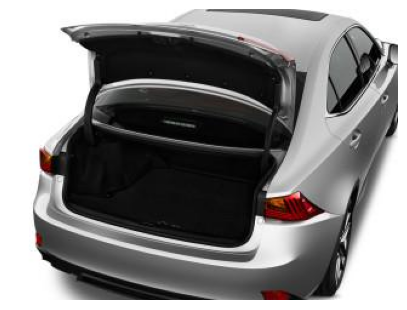

In [186]:
# Listing a sample car image
 
img = image.load_img('data2/images/train/'+class_+'/'+data[0])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [187]:
# Generate batches of tensor image data with real-time data augmentation

train_datagen = ImageDataGenerator(
     rotation_range=30, # angle range by which the images will randomly rotate
     rescale=1./255.,
     width_shift_range=0.1, # vertical image transformations
     height_shift_range=0.1, # horizontal image transformations
     shear_range=0.1, # random image cropping range
     zoom_range=0.2, # random image zoom range
     horizontal_flip=True, # random flip of half the image in the horizontal plane
     fill_mode='nearest' # strategy for filling newly created pixels that may result from transformations
)

train_gen = train_datagen.flow_from_directory('data2/images/train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical')
test_gen = ImageDataGenerator().flow_from_directory('data2/images/test',
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 28227 images belonging to 10 classes.
Found 7056 images belonging to 10 classes.


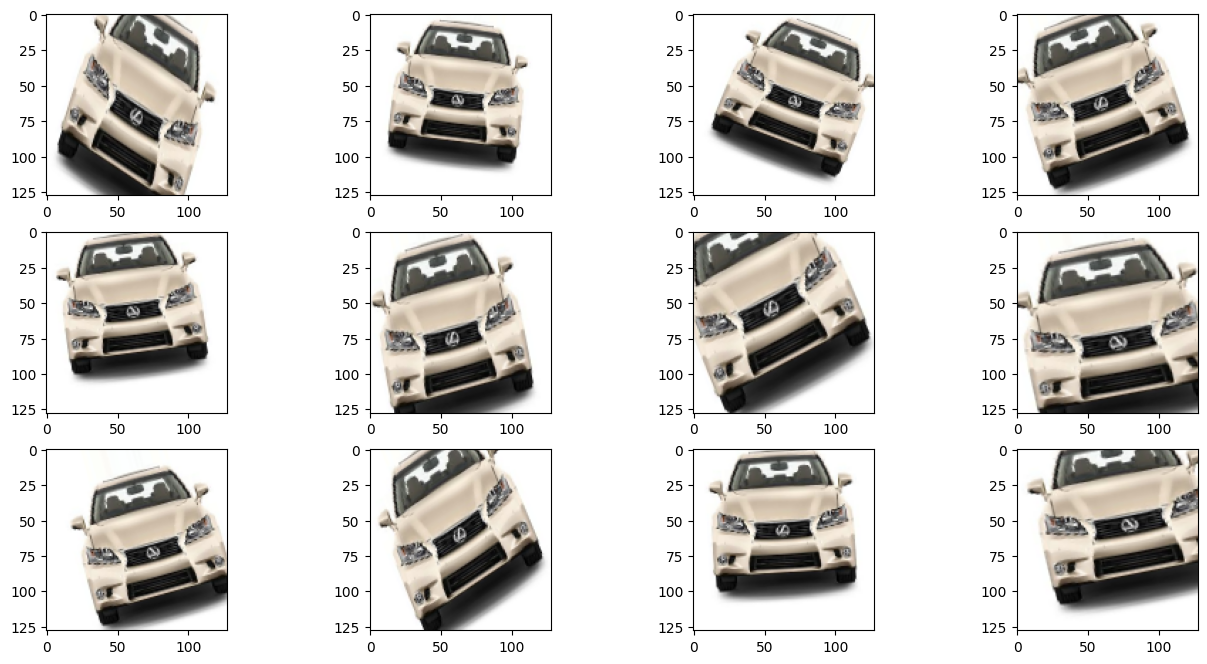

In [188]:
# Sample images obtained using the technique data augmentation

img = image.load_img('data2/images/train/'+class_+'/'+data[11],target_size=(128, 128))# plt.imshow(img)
#img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 1
plt.figure(figsize=(16, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
        break

## Build model

The model is a Convolutional Neural Network (CNN) model that is built upon a pre-trained VGG16 architecture for image feature extraction and classification. Here's a step-by-step explanation of the model:

VGG16 Base Model:

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)): In this part, you create a base model using VGG16. This model has been pre-trained on the large ImageNet dataset and is known for its ability to extract features from images.
weights='imagenet' indicates that the model will use weights pre-trained on ImageNet data. This means that the VGG16 model already has learned filters and weights, which are used as a starting point for the new task.
include_top=False means that you exclude the fully connected layers at the top of the VGG16 model, as you'll be adding your own classification layers.
input_shape=(128, 128, 3) specifies the input shape for your images, which are 128x128 pixels with three color channels (RGB).
Freezing the Base Model Weights:

conv_base.trainable = False: With this line of code, you freeze the weights of the base VGG16 model. This means that these weights will not be updated during training. You are using these pre-trained weights for feature extraction while keeping them fixed.
Sequential Model:

You create a new model using Sequential(), and you add the following layers:
model.add(conv_base): You add the pre-trained VGG16 base model to your new model. At this point, your base model is VGG16 with frozen weights.
model.add(layers.Flatten()): You add a flattening layer, which transforms the output from the VGG16 base model into a one-dimensional vector that can be used as input to fully connected layers.
model.add(layers.Dense(units=256, activation='relu'): You add a fully connected layer with 256 units and ReLU activation. This layer is used for learning features based on the extracted features from the VGG16 model.
model.add(layers.Dense(units=10, activation='softmax'): You add an output layer with 10 units (representing 10 classes) and a softmax activation function. This layer generates probabilities for each class.
Model Compilation:

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"]): You compile the model, setting the loss function to categorical cross-entropy, the optimizer to "adam," and specifying that you want to track accuracy as a metric.
Model Summary:

model.summary(): This line of code generates a summary of the model's architecture, showing the number of parameters and dimensions for each layer.
In summary, this model uses the VGG16 architecture as a feature extractor, adds a few custom layers for classification, and is suitable for tasks like image classification where transfer learning from a pre-trained model can be highly effective. The weights of the VGG16 base model are kept fixed, and the new layers are trained on top of the extracted features.

Based on previous models, the number of epochs was set to 5 because a higher value did not improve the model

In [189]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base.trainable = False

In [190]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 2099978 (8.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [191]:
history = model.fit(train_gen, validation_data=test_gen, batch_size=6000, epochs=5)

Epoch 1/5
883/883 [==============================] - 1295s 1s/step - loss: 2.1477 - accuracy: 0.2192 - val_loss: 50.1616 - val_accuracy: 0.1855
Epoch 2/5
883/883 [==============================] - 1542s 2s/step - loss: 1.9964 - accuracy: 0.2883 - val_loss: 57.5273 - val_accuracy: 0.1990
Epoch 3/5
883/883 [==============================] - 1532s 2s/step - loss: 1.9161 - accuracy: 0.3202 - val_loss: 60.6563 - val_accuracy: 0.2181
Epoch 4/5
883/883 [==============================] - 1500s 2s/step - loss: 1.8550 - accuracy: 0.3472 - val_loss: 67.9470 - val_accuracy: 0.2242
Epoch 5/5
883/883 [==============================] - 1521s 2s/step - loss: 1.8109 - accuracy: 0.3624 - val_loss: 71.2163 - val_accuracy: 0.2260


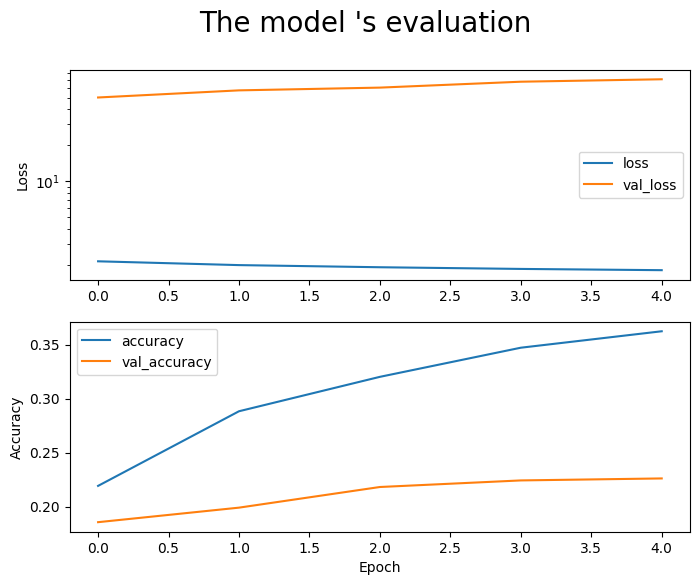

In [192]:
plot_hist(history)

In [193]:
model.save('models/vgg_model_2_10.h5')

/Users/marcin/.virtualenvs/ds2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [194]:
hist_df_vgg_2 = pd.DataFrame(history.history)

## Test model

In [195]:
# Preparation of test data

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    'data2/images/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 7056 images belonging to 10 classes.


In [196]:
# Raad class indices

test_generator.class_indices

{'Audi': 0,
 'BMW': 1,
 'Chevrolet': 2,
 'Ford': 3,
 'Honda': 4,
 'Kia': 5,
 'Lexus': 6,
 'Mercedes-Benz': 7,
 'Nissan': 8,
 'Toyota': 9}

In [197]:
classes = list(test_generator.class_indices.keys())

In [198]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [200]:
# Predict model

y_prob = model.predict(test_generator, test_generator.samples)

7056/7056 [==============================] - 348s 49ms/step


In [201]:
y_pred = np.argmax(y_prob, axis=1)

In [202]:
# Show confusion matrix

cm = confusion_matrix(y_true, y_pred)
cm

array([[325, 115,  41,  37,  22,   1,   1,  56,  28,   0],
       [ 69, 488,  58,  49,  22,   4,   2,  84,  40,   8],
       [ 61, 121, 543, 128,  42,   6,   0,  43,  49,  23],
       [ 54, 136,  98, 445,  38,   6,   0,  55,  37,  14],
       [ 28,  75,  69,  87, 168,   2,   1,  44,  39,  22],
       [ 32, 101,  78,  73,  37,  17,   0,  26,  47,  21],
       [ 42, 108,  41,  40,  49,   5,  12,  58,  44,  26],
       [ 65, 140,  30,  56,  14,   9,   0, 268,  37,   0],
       [ 36, 117, 126, 134,  73,   2,   1,  57, 202,  28],
       [ 30, 137, 142, 222,  93,  14,   0,  53,  76, 153]])

In [203]:
# Show input test data class matrix
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

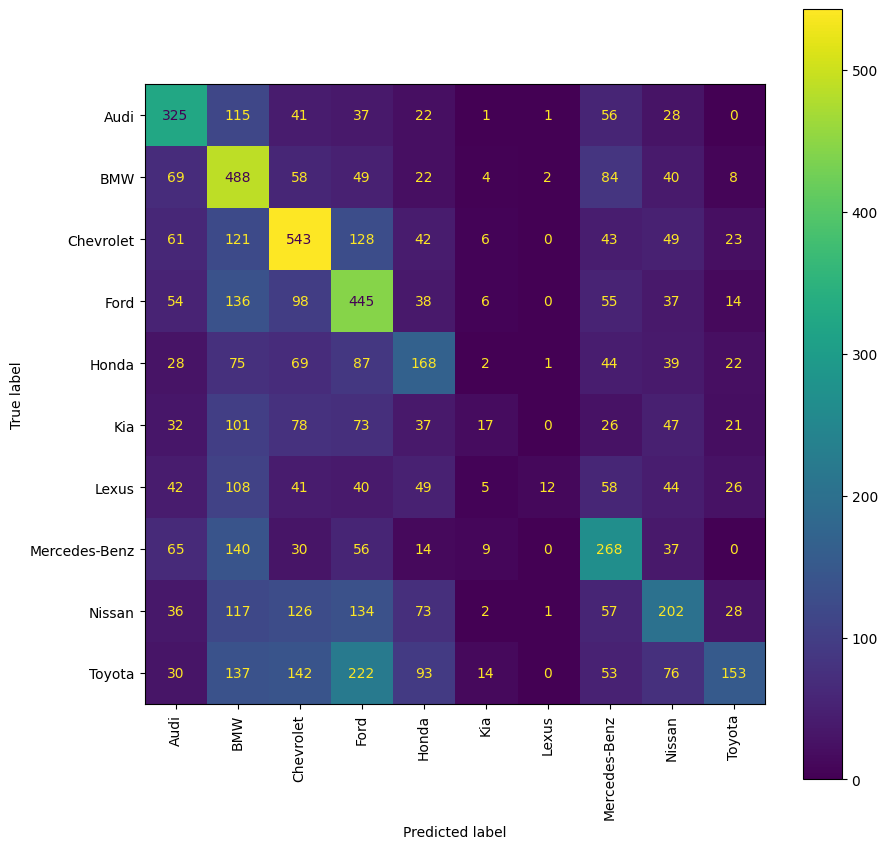

In [204]:
plot_confusion_matrix(cm)

In [205]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

         Audi       0.44      0.52      0.48       626
          BMW       0.32      0.59      0.41       824
    Chevrolet       0.44      0.53      0.48      1016
         Ford       0.35      0.50      0.41       883
        Honda       0.30      0.31      0.31       535
          Kia       0.26      0.04      0.07       432
        Lexus       0.71      0.03      0.05       425
Mercedes-Benz       0.36      0.43      0.39       619
       Nissan       0.34      0.26      0.29       776
       Toyota       0.52      0.17      0.25       920

     accuracy                           0.37      7056
    macro avg       0.40      0.34      0.32      7056
 weighted avg       0.40      0.37      0.34      7056



In [206]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

In [231]:
report_df

,precision,recall,f1-score,support
Audi,0.438005,0.519169,0.475146,626.000000
BMW,0.317295,0.592233,0.413209,824.000000
Chevrolet,0.442904,0.534449,0.484389,1016.000000
Ford,0.350118,0.503964,0.413185,883.000000
Honda,0.301075,0.314019,0.307411,535.000000
Kia,0.257576,0.039352,0.068273,432.000000
Lexus,0.705882,0.028235,0.054299,425.000000
Mercedes-Benz,0.360215,0.432956,0.393250,619.000000
Nissan,0.337229,0.260309,0.293818,776.000000
Toyota,0.518644,0.166304,0.251852,920.000000


## Verify final model

In [208]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred'])
print(f'Errors in all test files {test_generator.n}:')
errors['is_incorrect'].sum()

Errors in all test files 7056:


4435

In [209]:
test_generator.class_indices

{'Audi': 0,
 'BMW': 1,
 'Chevrolet': 2,
 'Ford': 3,
 'Honda': 4,
 'Kia': 5,
 'Lexus': 6,
 'Mercedes-Benz': 7,
 'Nissan': 8,
 'Toyota': 9}

#### BMW

In [233]:
errors[(errors['y_true'] == 1) & (errors['is_incorrect'] == False)]

,y_true,y_pred,is_incorrect
BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_pVm.jpg,1,1,False
BMW/BMW_2-Series_2015_37_17_240_20_4_69_55_174_23_RWD_4_2_Convertible_NAP.jpg,1,1,False
BMW/BMW_2-Series_2015_37_17_240_20_4_69_55_174_23_RWD_4_2_Convertible_UxC.jpg,1,1,False
BMW/BMW_2-Series_2015_37_17_240_20_4_69_55_174_23_RWD_4_2_Convertible_Wwn.jpg,1,1,False
BMW/BMW_2-Series_2015_37_17_240_20_4_69_55_174_23_RWD_4_2_Convertible_eHV.jpg,1,1,False
...,...,...,...
BMW/BMW_i8_2015_136_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_kcT.jpg,1,1,False
BMW/BMW_i8_2016_140_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_CGM.jpg,1,1,False
BMW/BMW_i8_2016_140_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_yXK.jpg,1,1,False
BMW/BMW_i8_2020_147_20_360_15_3_76_50_184_nan_AWD_4_2_2dr_SVI.jpg,1,1,False


1/1 [==============================] - 0s 56ms/step
{'Class': 'BMW', 'Probability': 0.36005357}


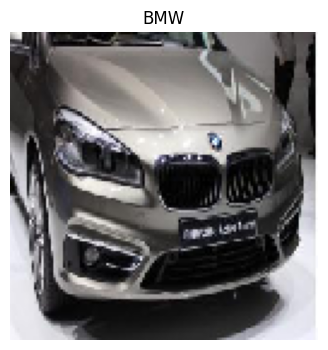

In [216]:
plot_img(model,'data2/images/test/','BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_pVm.jpg')

In [217]:
# Show correct prediction for Lexus, y_true = 6  
errors[(errors['y_true'] == 1) & (errors['is_incorrect'] == True)]

,y_true,y_pred,is_incorrect
BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_CmZ.jpg,1,2,True
BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_Ddq.jpg,1,3,True
BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_EtY.jpg,1,2,True
BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_Fsx.jpg,1,3,True
BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_KBM.jpg,1,3,True
...,...,...,...
BMW/BMW_i8_2015_136_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_WkZ.jpg,1,7,True
BMW/BMW_i8_2015_136_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_iBe.jpg,1,0,True
BMW/BMW_i8_2015_136_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_ouj.jpg,1,8,True
BMW/BMW_i8_2015_136_20_350_15_3_76_50_184_nan_AWD_4_2_2dr_taK.jpg,1,2,True


1/1 [==============================] - 0s 48ms/step
{'Class': 'Chevrolet', 'Probability': 0.19958985}


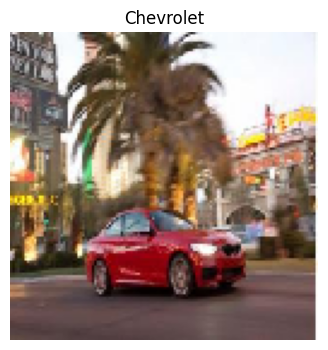

In [218]:
plot_img(model, 'data2/images/test/','BMW/BMW_2-Series_2014_32_17_240_20_4_69_55_174_23_RWD_4_2_2dr_CmZ.jpg')

#### Toyota

In [236]:
 errors[(errors['y_true'] == 9) & (errors['is_incorrect'] == False)]

,y_true,y_pred,is_incorrect
Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_rAb.jpg,9,9,False
Toyota/Toyota_4Runner_2014_43_20_270_40_6_75_71_191_17_4WD_5_4_SUV_Beq.jpg,9,9,False
Toyota/Toyota_4Runner_2015_43_20_270_40_6_75_71_190_17_4WD_5_4_SUV_dAJ.jpg,9,9,False
Toyota/Toyota_4Runner_2016_44_20_270_40_6_75_71_190_17_4WD_5_4_SUV_GER.jpg,9,9,False
Toyota/Toyota_4Runner_2017_42_20_270_40_6_75_71_190_17_RWD_5_4_SUV_CZO.jpg,9,9,False
...,...,...,...
Toyota/Toyota_Yaris_2016_15_15_100_15_4_66_59_155_30_FWD_5_2_2dr_Pww.jpg,9,9,False
Toyota/Toyota_Yaris_2016_15_15_100_15_4_66_59_155_30_FWD_5_2_2dr_xwI.jpg,9,9,False
Toyota/Toyota_Yaris_2017_16_15_100_15_4_66_59_155_30_FWD_5_2_2dr_sLd.jpg,9,9,False
Toyota/Toyota_Yaris_2019_16_15_100_15_4_66_58_171_32_FWD_5_4_4dr_JMv.jpg,9,9,False


1/1 [==============================] - 0s 49ms/step
{'Class': 'Toyota', 'Probability': 0.37927565}


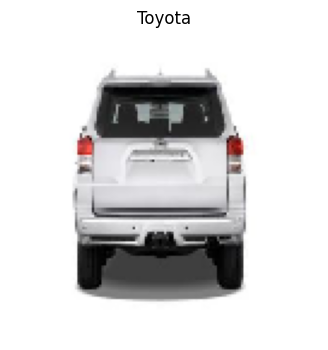

In [237]:
plot_img(model,'data2/images/test/','Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_rAb.jpg')

In [238]:
 errors[(errors['y_true'] == 9) & (errors['is_incorrect'] == True)]

,y_true,y_pred,is_incorrect
Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_MxR.jpg,9,2,True
Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_OWY.jpg,9,2,True
Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_VZj.jpg,9,7,True
Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_iwL.jpg,9,4,True
Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_mWi.jpg,9,3,True
...,...,...,...
Toyota/Toyota_Yaris_2020_16_15_100_15_4_66_58_171_32_FWD_5_4_4dr_FcF.jpg,9,3,True
Toyota/Toyota_Yaris_2020_16_15_100_15_4_66_58_171_32_FWD_5_4_4dr_OkE.jpg,9,3,True
Toyota/Toyota_Yaris_2020_16_15_100_15_4_66_58_171_32_FWD_5_4_4dr_ciw.jpg,9,8,True
Toyota/Toyota_Yaris_2020_16_15_100_15_4_66_58_171_32_FWD_5_4_4dr_kKc.jpg,9,8,True


1/1 [==============================] - 0s 50ms/step
{'Class': 'Chevrolet', 'Probability': 0.33010745}


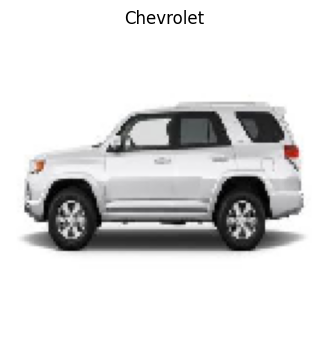

In [239]:
plot_img(model,'data2/images/test/','Toyota/Toyota_4Runner_2011_40_20_270_40_6_75_70_189_17_4WD_5_4_SUV_MxR.jpg')

## Summary

Overall, the use of a large number of photos of car brands did not improve the results obtained in the model - the overall accuracy dropped from 45% to 40%. However, the results obtained are satisfactory and it can be seen that the Ferrari brand, which is characterized by the specific shape of its cars, achieved a precision of over 70%. The problem is that many brands of popular cars are similar and small details distinguish them from each other. The logo is definitely an element that clearly identifies the brand, but it is invisible in many photos and reducing the size of the photos means that it is often unrecognizable. Therefore, obtaining average accuracy based on photos from the Internet with an average resolution of 300x200 is a very good result.